In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
class BernoulliBanditEnv(object): 
    # Clase que define el environment donde el reward es 0 o 1 dependiendo de una probabilidad p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # La mejor accion dado el enviroenmentenenas

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [328]:
class Agent(object):
    # Clase que define al agente. Cada agente cuenta con una regla de decisión y una regla de aprendizaje.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
        
        if decision_rule == "gradient":
            self.lr = param["lr"]
    
    def environment(self, env, init_q):
        # inicializa el environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta  = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # Guardo last_reward para el gradient bandits
        if self.decision_rule == "gradient":
            self.last_action = a
            self.last_reward = r
        
        # dada una acción y una recompenza, actualiza la value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a]  += 1 - r 
            
    def act(self):
        # realiza una acción.
        self.iteration += 1 
        
        if self.decision_rule == "greedy":
            selected_action = greedyAction(self.q_estimate)
            pass
        if self.decision_rule == "epsilon-greedy":
            selected_action = epsilonGreedyAction(self.q_estimate, self.epsilon)
            pass
        if self.decision_rule == "UCB":
            selected_action = upperConfidenceBoundAction(self.q_estimate, self.UCB_param, self.iteration, self.act_count)
            pass
        if self.decision_rule == "gradient":
            # Tomar H (self.pref) como mi funcion de preferencia que actualiza cuando compara
            # el reward R que obtuve con mi reward promedio estimado R^
            # Debo actualizar dos cosas:
            #    la preferencia de la accion que tome (aumenta o disminuye)
            #    la preferencia de las otras acciones (disminuyen o aumentan)
            for a in self.actions:
                # softmax: pi = e**pref(a)/sum(e**pref(all-a))
                # pi = softmax(pref(a), pref)
                # TODO: Preguntar:
                #       0. hacerlo matricialmentel, no con un ciclo mugroso
                #       1. uso q_estimate como promedio de rewards, no se si es lo correcto
                #       2. esta bien considerar la funcion de preferencia una probabilidad? o puede tomar valores negativos?
                if self.iteration == 1:
                    # first action decision, without having rewards
                    # Equal preferences for each action
                    self.pref = np.empty(self.k)
                    self.pref.fill(1.0/self.k)
                    pass
                else:
                    pi = softmax_vect(self.pref)
                    r_diff = self.last_reward - self.q_estimate[self.last_action]
                    if a == self.last_action:
                        self.pref[a] += self.lr * r_diff * (1-pi[a])
                    else:
                        self.pref[a] -= self.lr * r_diff * pi[a]
            # making sure we dont get negatives 
            self.pref = np.maximum(0, self.pref)         
            # making sure pref is prob distribution function (sums to one)
            self.pref = self.pref / np.sum(self.pref)
            selected_action = np.random.choice(self.actions, p=self.pref)
            if self.iteration % 100 == 0:
                print(self.iteration, self.pref, selected_action)
            #self.last_action = selected_action
            pass
        if self.decision_rule == "Thompson":
            # COMPLETAR
            pass
        self.act_count[selected_action] += 1
        return selected_action

In [329]:
def greedyAction(q_estimate):
    # Choose greedly one of the best actions
    return randomArgmax(q_estimate)

def epsilonGreedyAction(q_estimate, eps):
    # Greedy action with prob p=1-eps, random with prob eps=1-p
    if np.random.choice([True, False], p=[1-eps, eps]):
        # Greedy action
        return greedyAction(q_estimate)
    else:
        # Random action
        return np.random.choice(np.arange(len(q_estimate)))

def upperConfidenceBoundAction(q_estimate, c, iteration, act_count):
    # De Sutton:
    # "if action a was never chosen > a is a maximizing action"
    # NO quiero que las acciones jamas elegidas 'me pisen' acciones con
    # pesos fuertes por tener peso infinito al dividir por cero.
    uncertainty = np.sqrt(np.log(iteration)/np.maximum(1, act_count))
    # Con 'maximizing action' de Sutton, elijo su valor a partir del maximo de las
    # acciones ya elegidas.
    # ie: Las acciones no elegidas tienen EL MISMO valor que LA MEJOR accion elegida hasta el momento
    # 1. q_estimate + uncertainty para acciones ya elegidas (ignoro las NO elegidas)
    part_candidates = q_estimate + c*np.where(act_count>0, uncertainty, 0)
    # 2. le doy el max puntaje (de q_estimate) a las acciones NO elegidas
    candidates = np.where(act_count>0, part_candidates, np.amax(part_candidates))
    return randomArgmax(candidates)

In [330]:
np.arange(4)

array([0, 1, 2, 3])

In [331]:
def randomArgmax(v):
    # Like argmax(), but if several "best" actions, chooses one randomly
    arguments = np.argwhere(v == np.amax(v)).ravel()
    arg = np.random.choice(arguments)
    return arg

In [332]:
def softmax_vect(v):
    """Returns a vector with all softmax values"""
    exp_vect = np.exp(v)
    return exp_vect/np.sum(exp_vect)

## Gradient Bandits

Gradient bandits actualiza la preferencia de cada accion deacuerdo a 
la diferencia entre el reward obtenido y el promedio

<img src="img/gradient-bandits.png" width="500" align="left" />

In [333]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # función que realiza las simulaciones de los agentes. Se define el número de repeticiones que seran
    #  promediadas y el número de pasos N. agents es una lista de agentes.
    
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [334]:
def plot_results(agents, actions, rewards):
    # Simulates and plot data
    # Number of steps to play
    N = 2000
    # We play for 'N' steps, then repeat for 'reps' times, and take the mean
    reps = 100
    # Generating data
    data = np.asarray(simulateBandits(agents, narms=actions, initp=rewards, initq=None, repetitions=reps, N=N))
    time_steps = np.arange(1, len(data[0])+1)
    plt.subplots(3, 1, figsize=(10, 15))
    # Subplot 1: Rewards over time
    plt.subplot(3, 1, 1)
    plt.title("Rewards over time")
    plt.xlabel("time step")
    plt.ylabel("reward")
    plt.grid()
    plt.plot(time_steps, data[0,:], 'r.-', label=None, linewidth=0.2)
    # Subplot 2: Agent's rate of choosing best arm
    plt.subplot(3, 1, 2)
    plt.title("Rate of choosing best arm")
    plt.xlabel("time step")
    plt.ylabel("rate")
    plt.grid()
    plt.plot(time_steps, data[1,:], 'b.-', label=None, linewidth=0.2)
    # Subplot 3: Cumulative reward
    plt.subplot(3, 1, 3)
    plt.title("Cumulative reward")
    plt.xlabel("time step")
    plt.ylabel("cumulative reward")
    plt.grid()
    plt.plot(time_steps, np.cumsum(data[1,:]), 'r.', label=None, markersize=2, linewidth=0.5)
    plt.plot([time_steps[0], time_steps[-1]] ,
             [np.cumsum(data[1,:])[0], np.cumsum(data[1,:])[-1]],
             'ko-', label="Strainght line", markersize=4, linewidth=0.5)

    
    plt.tight_layout()
    plt.show()

# Ejercicios:

1) Completar pertinentemente el código donde diga "COMPLETAR".

2) Realizar simulaciones con un bandit de 2 brazos (P = [0.4, 0.8]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

3) Realizar simulaciones con un bandit de 10 brazos (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

4) Estudie la dependencia del hiperparametro epsilon en la regla de decisión epsilon-greedy.


## Bandits de 2 brazos

### Greedy

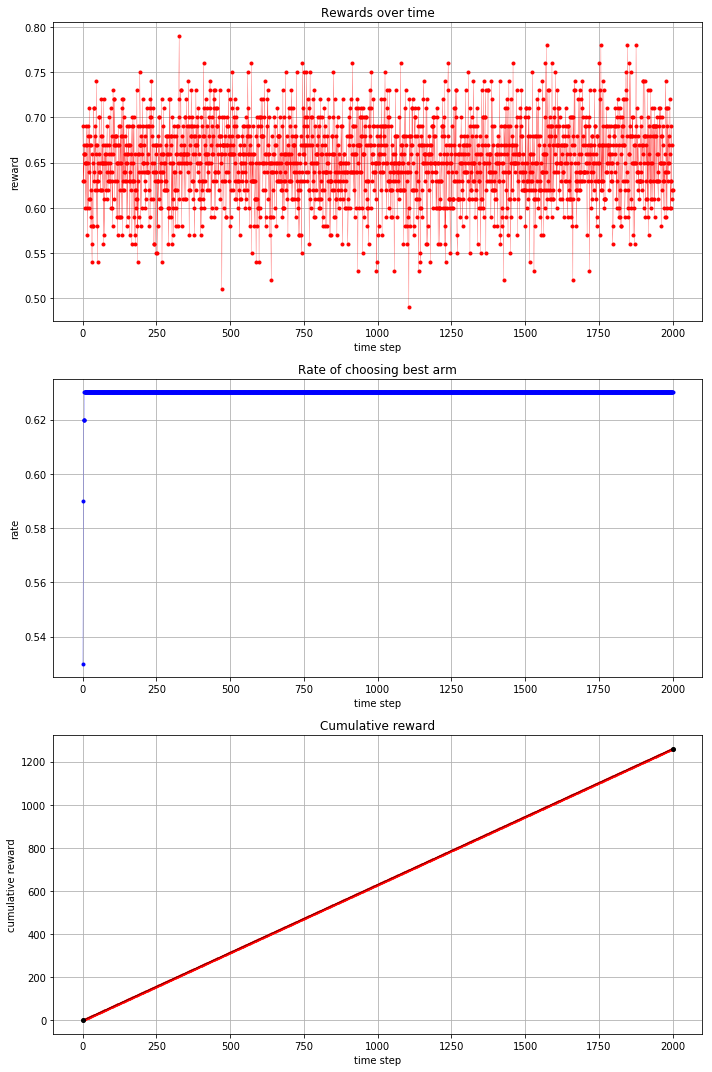

In [335]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon-Greedy

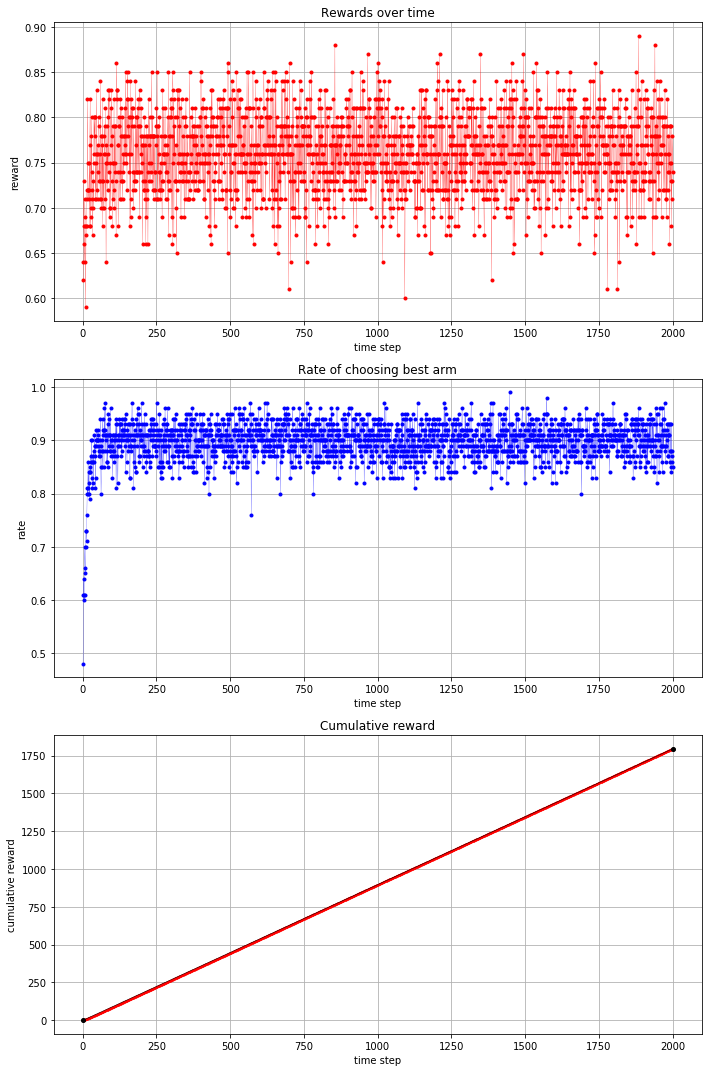

In [336]:
params = {"epsilon": 0.2}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### UCB

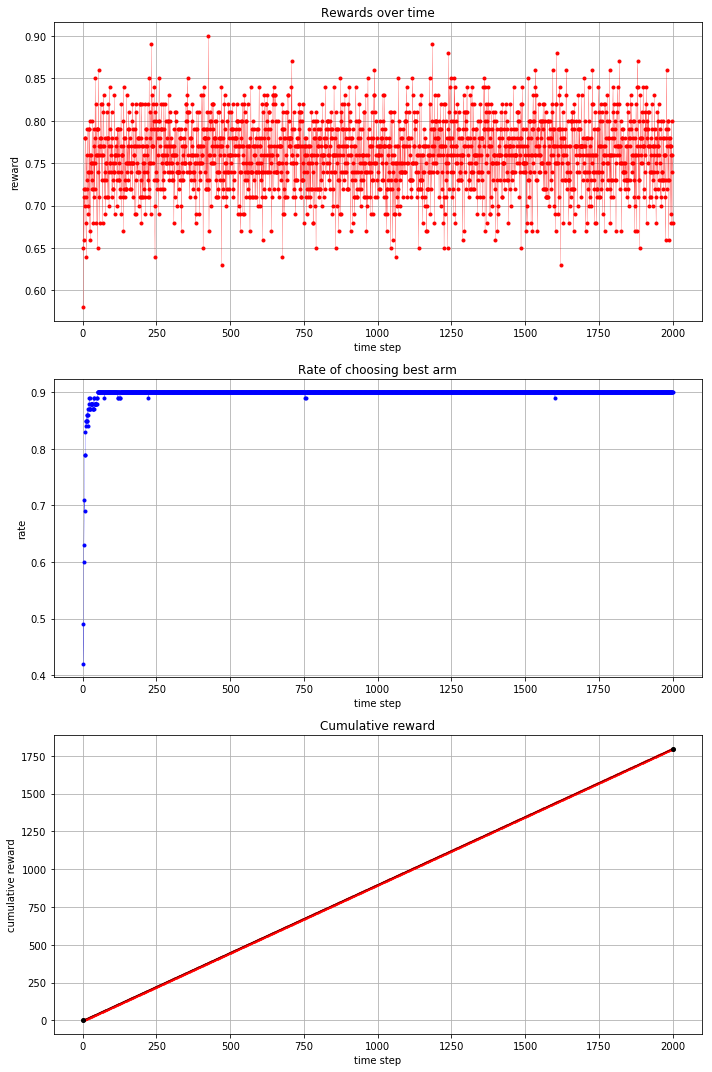

In [337]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Gradient

100 [0.60730707 0.39269293] 0
200 [0.68006733 0.31993267] 1
300 [0.41622697 0.58377303] 1
400 [0.29194951 0.70805049] 1
500 [0.27389782 0.72610218] 1
600 [0.20576312 0.79423688] 1
700 [0.2611352 0.7388648] 0
800 [0.1705871 0.8294129] 1
900 [0.07911564 0.92088436] 1
1000 [0.27047411 0.72952589] 1
1100 [0.46010509 0.53989491] 1
1200 [0.3937861 0.6062139] 1
1300 [0.36862444 0.63137556] 0
1400 [0.57279087 0.42720913] 1
1500 [0.50247496 0.49752504] 1
1600 [0.38091619 0.61908381] 1
1700 [0.0730332 0.9269668] 1
1800 [0.19331934 0.80668066] 1
1900 [0.42654736 0.57345264] 1
2000 [0.28264944 0.71735056] 0
100 [0.6466089 0.3533911] 1
200 [0.42529241 0.57470759] 1
300 [0.44791938 0.55208062] 0
400 [0.44953588 0.55046412] 1
500 [0.798669 0.201331] 0
600 [0.92704395 0.07295605] 0
700 [0.78023208 0.21976792] 0
800 [0.9095327 0.0904673] 0
900 [0.87396303 0.12603697] 0
1000 [0.68252965 0.31747035] 1
1100 [0.89766397 0.10233603] 0
1200 [0.75950307 0.24049693] 0
1300 [0.54472618 0.45527382] 0
1400 [0.848

500 [0.03172903 0.96827097] 1
600 [0.11107316 0.88892684] 1
700 [0.5384733 0.4615267] 0
800 [0.3800511 0.6199489] 0
900 [0.01693409 0.98306591] 1
1000 [0.15648942 0.84351058] 1
1100 [0.011952 0.988048] 1
1200 [0.30505983 0.69494017] 1
1300 [0.24371613 0.75628387] 0
1400 [0.17505273 0.82494727] 0
1500 [0.29615304 0.70384696] 1
1600 [0.30344763 0.69655237] 1
1700 [0.29558094 0.70441906] 1
1800 [0.26996535 0.73003465] 1
1900 [0.2133719 0.7866281] 1
2000 [0.0677165 0.9322835] 1
100 [0.85480786 0.14519214] 0
200 [0.79497995 0.20502005] 1
300 [0.91074526 0.08925474] 0
400 [0.67946628 0.32053372] 0
500 [0.92581144 0.07418856] 0
600 [0.88749369 0.11250631] 0
700 [1. 0.] 0
800 [0.84527999 0.15472001] 1
900 [0.4342441 0.5657559] 1
1000 [0.74775721 0.25224279] 0
1100 [0.92957403 0.07042597] 0
1200 [0.77951312 0.22048688] 0
1300 [0.73078103 0.26921897] 1
1400 [0.59217885 0.40782115] 0
1500 [0.66104213 0.33895787] 1
1600 [0.97725722 0.02274278] 0
1700 [0.99324216 0.00675784] 0
1800 [0.9135214 0.086

1300 [0.66486941 0.33513059] 1
1400 [0.3014879 0.6985121] 0
1500 [0.57868012 0.42131988] 0
1600 [0.84831468 0.15168532] 0
1700 [0.93143195 0.06856805] 0
1800 [0.89430717 0.10569283] 0
1900 [0.99716811 0.00283189] 0
2000 [0.96668429 0.03331571] 0
100 [0.60427872 0.39572128] 0
200 [0.67241355 0.32758645] 1
300 [0.97339405 0.02660595] 0
400 [0.93143015 0.06856985] 0
500 [0.73212746 0.26787254] 0
600 [0.74733453 0.25266547] 0
700 [0.86739754 0.13260246] 0
800 [0.81663077 0.18336923] 0
900 [0.81044928 0.18955072] 0
1000 [0.82430966 0.17569034] 0
1100 [0.80333702 0.19666298] 0
1200 [0.66580747 0.33419253] 0
1300 [0.35355898 0.64644102] 1
1400 [0.36466288 0.63533712] 0
1500 [0.77875534 0.22124466] 0
1600 [0.95381222 0.04618778] 0
1700 [0.81680757 0.18319243] 0
1800 [0.76374407 0.23625593] 0
1900 [0.92402768 0.07597232] 0
2000 [0.81847622 0.18152378] 0
100 [0.31393095 0.68606905] 0
200 [0.30051265 0.69948735] 0
300 [0.3818364 0.6181636] 1
400 [0.15109699 0.84890301] 1
500 [0.24609888 0.7539011

400 [0.91279185 0.08720815] 0
500 [0.87366516 0.12633484] 1
600 [0.94161079 0.05838921] 0
700 [1. 0.] 0
800 [0.83259229 0.16740771] 1
900 [0.97340306 0.02659694] 0
1000 [0.805551 0.194449] 0
1100 [0.95771951 0.04228049] 0
1200 [0.86824574 0.13175426] 0
1300 [0.89030515 0.10969485] 0
1400 [0.76766173 0.23233827] 0
1500 [0.61395925 0.38604075] 1
1600 [0.97228661 0.02771339] 0
1700 [0.63712572 0.36287428] 1
1800 [0.53473051 0.46526949] 0
1900 [0.81985823 0.18014177] 0
2000 [0.67552232 0.32447768] 1
100 [0.34191039 0.65808961] 1
200 [0.33864024 0.66135976] 1
300 [0.45954758 0.54045242] 0
400 [0.55758089 0.44241911] 0
500 [0.57995732 0.42004268] 0
600 [0.57770228 0.42229772] 1
700 [0.49920574 0.50079426] 1
800 [0.61490089 0.38509911] 1
900 [0.7562374 0.2437626] 0
1000 [0.91406936 0.08593064] 1
1100 [0.9833254 0.0166746] 0
1200 [0.98975463 0.01024537] 0
1300 [0.95236973 0.04763027] 0
1400 [0.96795693 0.03204307] 0
1500 [0.96800427 0.03199573] 0
1600 [0.98912975 0.01087025] 0
1700 [0.90713605

200 [0.41890141 0.58109859] 0
300 [0.37543997 0.62456003] 0
400 [0.2139307 0.7860693] 1
500 [0.40862551 0.59137449] 1
600 [0.2261388 0.7738612] 0
700 [0.27558377 0.72441623] 0
800 [0.26247993 0.73752007] 1
900 [0.44756245 0.55243755] 1
1000 [0.48962987 0.51037013] 0
1100 [0.96702715 0.03297285] 0
1200 [0.78107232 0.21892768] 0
1300 [0.86602219 0.13397781] 0
1400 [0.86043662 0.13956338] 0
1500 [0.29012638 0.70987362] 1
1600 [0.32030356 0.67969644] 0
1700 [0.34137151 0.65862849] 1
1800 [0.27640178 0.72359822] 1
1900 [0.04636596 0.95363404] 1
2000 [0.05014201 0.94985799] 1
100 [0.66218228 0.33781772] 0
200 [0.9944337 0.0055663] 0
300 [0.97027747 0.02972253] 0
400 [0.8291149 0.1708851] 0
500 [0.79983294 0.20016706] 0
600 [0.77189129 0.22810871] 0
700 [0.91189239 0.08810761] 0
800 [0.95513031 0.04486969] 0
900 [0.91539628 0.08460372] 0
1000 [0.88630303 0.11369697] 0
1100 [0.93398225 0.06601775] 0
1200 [0.97833231 0.02166769] 0
1300 [0.90244803 0.09755197] 0
1400 [0.95544523 0.04455477] 0
15

1500 [0. 1.] 1
1600 [0.30690446 0.69309554] 1
1700 [0.16715757 0.83284243] 1
1800 [0.11422871 0.88577129] 0
1900 [0. 1.] 1
2000 [0.00736068 0.99263932] 1
100 [0.58445496 0.41554504] 1
200 [0.6459865 0.3540135] 0
300 [0.66339683 0.33660317] 0
400 [0.68145027 0.31854973] 1
500 [0.32050439 0.67949561] 0
600 [0.70373843 0.29626157] 0
700 [0.64725216 0.35274784] 0
800 [0.56319851 0.43680149] 0
900 [0.78526742 0.21473258] 1
1000 [0.86516513 0.13483487] 0
1100 [0.92550509 0.07449491] 0
1200 [0.70449944 0.29550056] 1
1300 [0.76459062 0.23540938] 0
1400 [0.86106116 0.13893884] 0
1500 [0.87887132 0.12112868] 0
1600 [0.90815806 0.09184194] 0
1700 [0.70710548 0.29289452] 0
1800 [0.75574451 0.24425549] 0
1900 [0.79309336 0.20690664] 0
2000 [0.74215366 0.25784634] 0
100 [0.97406626 0.02593374] 0
200 [0.96360144 0.03639856] 0
300 [0.90713947 0.09286053] 0
400 [0.35001156 0.64998844] 1
500 [0.33028655 0.66971345] 1
600 [0.32723873 0.67276127] 1
700 [0.60742034 0.39257966] 0
800 [0.53369649 0.46630351]

800 [0.22054266 0.77945734] 1
900 [0.31190121 0.68809879] 1
1000 [0.24072471 0.75927529] 1
1100 [0.06500424 0.93499576] 1
1200 [0.01046832 0.98953168] 1
1300 [0.02873953 0.97126047] 0
1400 [0.03621298 0.96378702] 1
1500 [0.09997901 0.90002099] 1
1600 [0.01917628 0.98082372] 1
1700 [0.04955037 0.95044963] 1
1800 [0.0463791 0.9536209] 1
1900 [0. 1.] 1
2000 [0.1510359 0.8489641] 1
100 [0.59852088 0.40147912] 0
200 [0.54228284 0.45771716] 0
300 [0.44495104 0.55504896] 1
400 [0.51296597 0.48703403] 0
500 [0.68531939 0.31468061] 0
600 [0.78465077 0.21534923] 0
700 [0.93531922 0.06468078] 0
800 [0.94676728 0.05323272] 0
900 [0.83964475 0.16035525] 0
1000 [0.40321002 0.59678998] 1
1100 [0.71736754 0.28263246] 0
1200 [0.97107388 0.02892612] 1
1300 [0.92195133 0.07804867] 0
1400 [0.78923537 0.21076463] 1
1500 [0.63459273 0.36540727] 0
1600 [0.39852496 0.60147504] 0
1700 [0.589789 0.410211] 0
1800 [0.9812294 0.0187706] 0
1900 [0.9894309 0.0105691] 0
2000 [0.94232791 0.05767209] 0
100 [0.75433816 

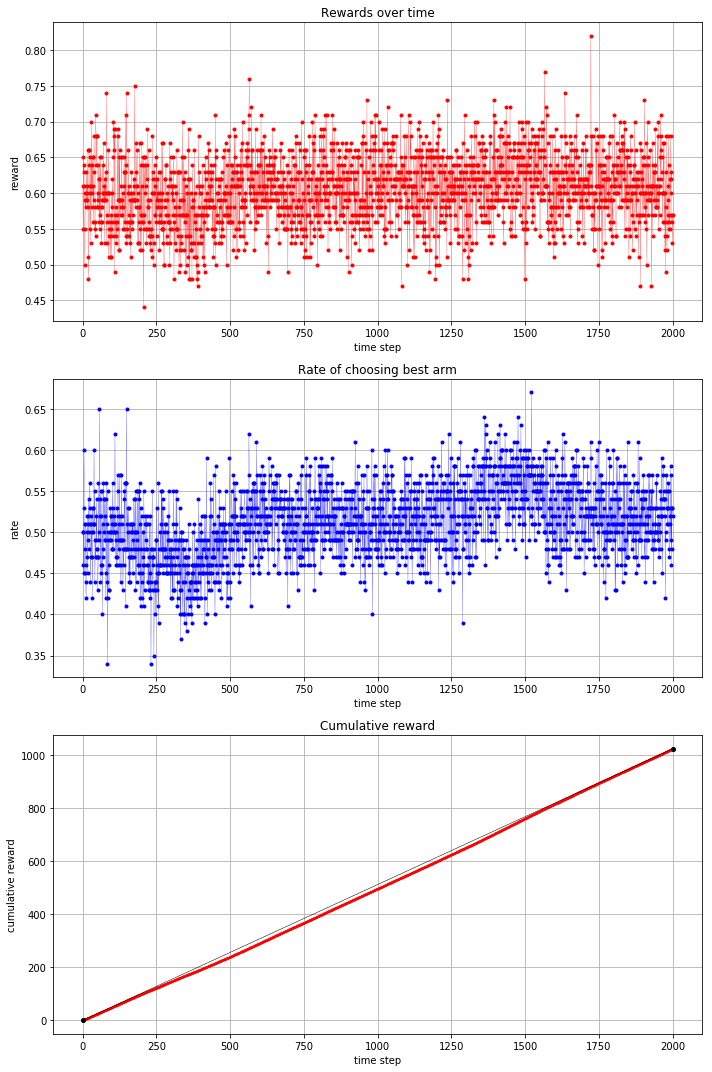

In [338]:
params = {"lr": 0.1}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Bandits de 10 brazos

#### Greedy

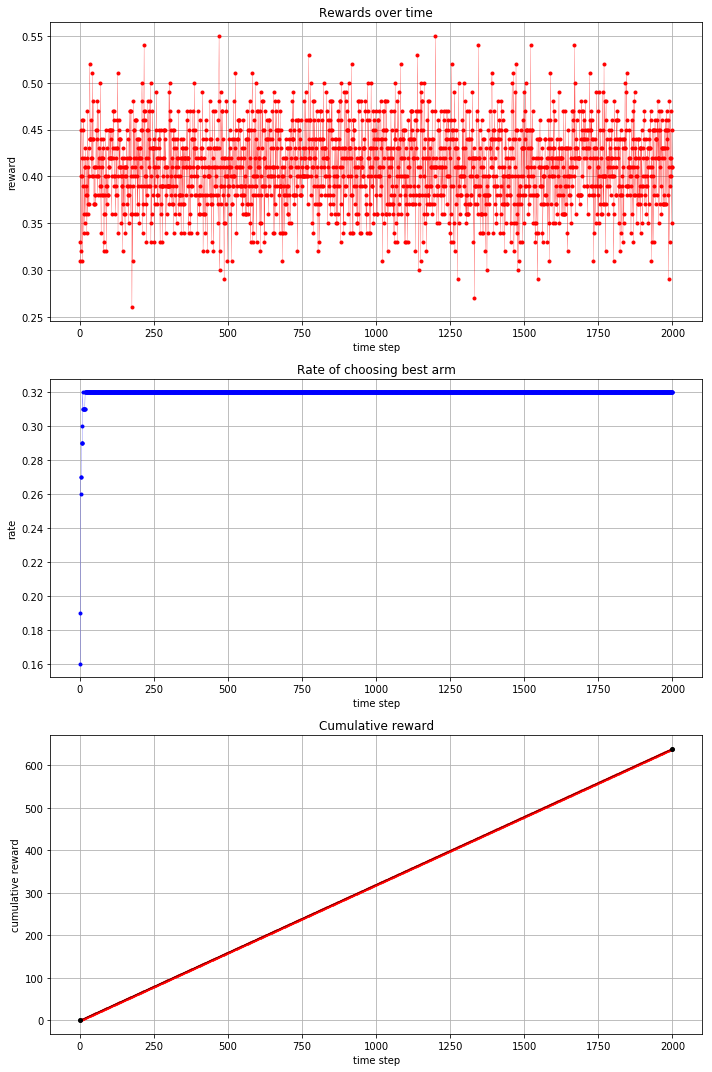

In [339]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon-Greedy

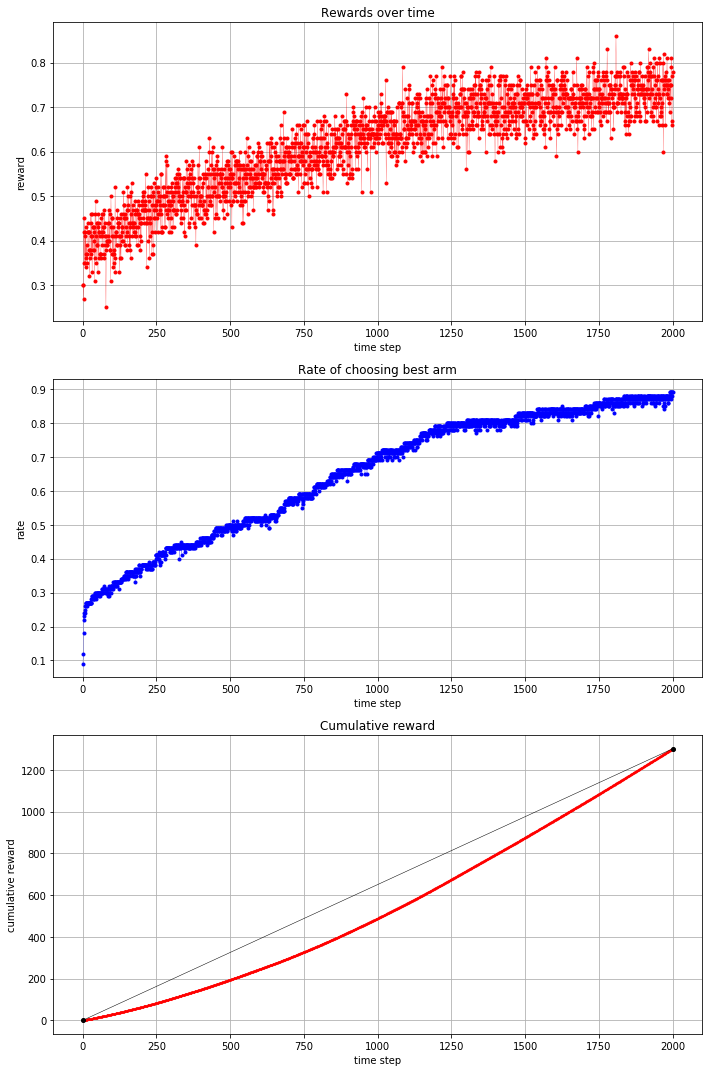

In [340]:
params = {"epsilon": 0.01}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### UCB

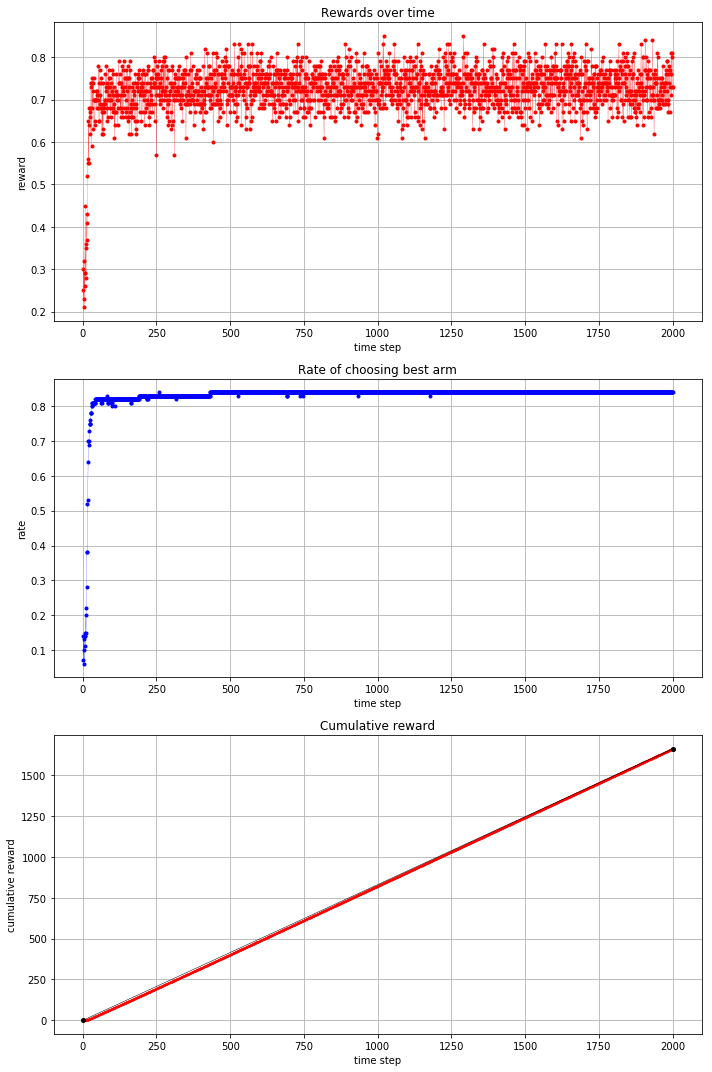

In [341]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Gradient

100 [0.01939055 0.11849173 0.02054854 0.13474772 0.08488483 0.01423627
 0.07698069 0.37223071 0.07358404 0.08490492] 7
200 [0.00124572 0.04328627 0.00120457 0.0982791  0.29966735 0.00121068
 0.10428765 0.40572945 0.00134305 0.04374614] 4
300 [0.00961886 0.25446391 0.03033431 0.02914785 0.08232893 0.00958664
 0.00958002 0.37146719 0.00964927 0.19382299] 7
400 [0.02885149 0.29132915 0.00149875 0.24647497 0.02015182 0.02876108
 0.02868913 0.2373028  0.02453947 0.09240134] 1
500 [0.01524627 0.40712589 0.01461208 0.06267816 0.01856054 0.01457991
 0.03300471 0.26648605 0.03032084 0.13738555] 6
600 [0.01974637 0.574323   0.00560044 0.00558187 0.01739281 0.01140274
 0.00556753 0.19887684 0.15393467 0.00757374] 1
700 [0.02365625 0.22569385 0.13307254 0.16691483 0.00781048 0.00159372
 0.01006594 0.19964269 0.10040136 0.13114834] 1
800 [0.04840119 0.10470783 0.34252483 0.0110298  0.02578102 0.049988
 0.0302378  0.10740329 0.23743164 0.0424946 ] 8
900 [0.01736663 0.24338863 0.03611776 0.01519467 0

300 [0.37310179 0.03831908 0.0607293  0.29833618 0.05034237 0.0031735
 0.0031726  0.03816283 0.08893184 0.0457305 ] 3
400 [0.5895787  0.00322277 0.00321188 0.34566528 0.00320557 0.0031946
 0.00318363 0.00317263 0.00316163 0.04240331] 0
500 [0.73284752 0.01518581 0.03115475 0.1249268  0.01518776 0.01517005
 0.01515232 0.01513457 0.02014156 0.01509886] 0
600 [0.71999535 0.04814834 0.0084356  0.03048724 0.09363367 0.0084304
 0.00995802 0.06265738 0.00842539 0.00982861] 0
700 [0.62098407 0.05707246 0.01764041 0.02303465 0.11784157 0.03194576
 0.03232415 0.06395218 0.01760686 0.0175979 ] 0
800 [0.5689316  0.08224334 0.09236804 0.13598866 0.0441564  0.00324628
 0.06333565 0.00324428 0.00324334 0.0032424 ] 2
900 [0.53706295 0.00543441 0.00870705 0.19391274 0.12637868 0.0086561
 0.01999406 0.06424723 0.00537982 0.03022696] 0
1000 [5.70920712e-01 2.78497180e-05 2.86273293e-03 1.50717833e-01
 7.01900255e-02 8.97539305e-06 3.53768921e-06 1.97478812e-01
 7.78952123e-03 0.00000000e+00] 7
1100 [0.37

900 [0.02538843 0.03099569 0.00686089 0.45517965 0.02553839 0.27497207
 0.02567991 0.03959551 0.09023304 0.02555641] 3
1000 [0.02154149 0.01448338 0.00197431 0.52654276 0.01470133 0.14964409
 0.0146402  0.00197635 0.001976   0.2525201 ] 3
1100 [0.05243226 0.22366363 0.00175621 0.46270745 0.00176017 0.03791671
 0.03093351 0.06597914 0.07333012 0.04952081] 8
1200 [0.         0.20613368 0.         0.58465675 0.         0.
 0.         0.         0.20920957 0.        ] 3
1300 [0.0308779  0.15611887 0.03085459 0.25046094 0.01379544 0.06094178
 0.03080535 0.02421445 0.39170914 0.01022153] 3
1400 [0.0146608  0.28352339 0.01474881 0.10203224 0.08093709 0.
 0.01469772 0.03834213 0.43635344 0.01470438] 1
1500 [5.36835501e-04 8.40622953e-02 2.63093784e-02 4.56315434e-02
 6.68212210e-02 1.71305164e-01 3.24195264e-02 5.00964948e-04
 5.36471647e-01 3.59414233e-02] 8
1600 [0.         0.         0.16441769 0.00569136 0.29924509 0.04788228
 0.03265022 0.11358812 0.33652524 0.        ] 4
1700 [0.03861227

1700 [0.06056943 0.11511993 0.04408906 0.24448299 0.22828018 0.01267251
 0.07511105 0.00995962 0.07635764 0.13335759] 4
1800 [0.03598245 0.24276493 0.18053441 0.09685494 0.09007304 0.01083781
 0.02919144 0.05166805 0.10247178 0.15962116] 1
1900 [0.01241871 0.08052789 0.05145794 0.11849212 0.32402134 0.01996271
 0.00310421 0.02691356 0.14450364 0.21859788] 8
2000 [0.03824353 0.27668721 0.06178045 0.09421401 0.1735713  0.04970851
 0.09370113 0.04923952 0.05445463 0.10839972] 4
100 [0.32970424 0.00528723 0.         0.06206432 0.02017541 0.18844452
 0.02226713 0.18353661 0.18852054 0.        ] 7
200 [0.21274341 0.06987316 0.04313325 0.0327507  0.05133401 0.25535231
 0.04862907 0.10842783 0.16226067 0.01549559] 5
300 [0.12270108 0.05801018 0.0438091  0.01301531 0.0582864  0.36057545
 0.05636731 0.00530276 0.14362149 0.13831091] 5
400 [0.26494246 0.00214769 0.00214728 0.00214687 0.04618881 0.62230211
 0.0021446  0.00214419 0.0350901  0.02074588] 5
500 [0.09033976 0.04675645 0.09019017 0.0290

800 [0.01815194 0.53619202 0.1177247  0.0270333  0.         0.02748078
 0.         0.         0.14044101 0.13297625] 2
900 [0.14369926 0.48350994 0.01964031 0.01374333 0.0380631  0.11668053
 0.02968966 0.04325728 0.04564348 0.06607312] 0
1000 [0.50859779 0.23607198 0.00507386 0.04255127 0.00937394 0.17010303
 0.0050704  0.00506963 0.00506885 0.01301926] 5
1100 [0.26664069 0.13299487 0.05829979 0.01191473 0.13840636 0.15714498
 0.0785641  0.13220293 0.01191733 0.01191423] 0
1200 [0.51599768 0.11562288 0.01322653 0.06693298 0.07836259 0.04552731
 0.03118445 0.10985272 0.01165387 0.01163898] 0
1300 [0.48130892 0.04445688 0.04545121 0.01802924 0.0267502  0.1864538
 0.04191048 0.04800125 0.00522415 0.10241386] 6
1400 [0.46845968 0.01123473 0.16940017 0.02450331 0.01125986 0.20979985
 0.05838726 0.02446105 0.01124868 0.01124542] 5
1500 [0.53682758 0.01074172 0.00205627 0.01444836 0.01074583 0.02469508
 0.15135602 0.22763967 0.01074646 0.01074302] 6
1600 [0.47111874 0.03678235 0.03675717 0.03

1600 [0.57080765 0.02088429 0.00924559 0.00924364 0.00924169 0.00923974
 0.28354492 0.06930337 0.00924553 0.00924358] 0
1700 [0.58180257 0.0559819  0.0050949  0.01734898 0.01397718 0.03874001
 0.14846027 0.11647992 0.00194053 0.02017373] 0
1800 [6.76015980e-01 4.12053371e-02 2.74864318e-02 2.40192619e-02
 4.25038726e-04 2.64145967e-02 1.52638923e-01 2.40051596e-02
 3.78092448e-03 2.40083474e-02] 0
1900 [0.39414116 0.03504775 0.07323521 0.05139685 0.01253008 0.05653448
 0.22373349 0.0379136  0.07308497 0.0423824 ] 0
2000 [0.59187335 0.01119739 0.07485268 0.04146121 0.00637516 0.01047209
 0.2362488  0.01702098 0.01049834 0.        ] 0
100 [0.0045551  0.1290211  0.07272854 0.03442917 0.08410033 0.2723697
 0.00458773 0.08411281 0.17305638 0.14103914] 5
200 [0.00782553 0.08726248 0.08655291 0.00782915 0.28219838 0.14676151
 0.00782696 0.00782543 0.06252923 0.30338843] 2
300 [0.02941738 0.00223329 0.09407635 0.00223231 0.42311167 0.35348825
 0.00223759 0.00310063 0.07125709 0.01884544] 4
400

600 [0.01566101 0.35314884 0.28741719 0.00845773 0.19575895 0.10575274
 0.00845375 0.00845184 0.00844993 0.00844803] 2
700 [0.01079224 0.30815353 0.34590982 0.01085543 0.12479165 0.15019095
 0.01083573 0.01683065 0.01082313 0.01081687] 4
800 [0.05982815 0.1630091  0.14640524 0.00565483 0.06225205 0.25198048
 0.13434918 0.07629343 0.02404211 0.07618544] 5
900 [0.03402753 0.13292397 0.06461774 0.02917895 0.06655593 0.20825298
 0.28108693 0.04142485 0.0403802  0.10155091] 6
1000 [0.04809349 0.27963145 0.08284903 0.06585812 0.0641787  0.03040227
 0.24389407 0.09902435 0.03359077 0.05247775] 1
1100 [0.109327   0.46328881 0.14562501 0.07134727 0.00885594 0.00885143
 0.06462685 0.         0.11919451 0.00888318] 0
1200 [0.09730601 0.45651482 0.00416971 0.24078924 0.00731175 0.04298314
 0.00417266 0.03309981 0.0341124  0.07954045] 1
1300 [0.09948356 0.43768917 0.00546654 0.00188954 0.04089589 0.02157128
 0.04079226 0.01801758 0.01800782 0.31618636] 1
1400 [0.1628401  0.3026243  0.00586059 0.   

1000 [0.09505008 0.0007764  0.00076763 0.00075886 0.20219227 0.00078569
 0.28621549 0.14633426 0.26632278 0.00079654] 8
1100 [0.02561698 0.02558286 0.02154977 0.02551921 0.06747584 0.07252016
 0.21071295 0.03903196 0.48629491 0.02569537] 5
1200 [0.03183986 0.03181632 0.03179276 0.18245347 0.07282624 0.02249523
 0.35029901 0.03190705 0.21266192 0.03190815] 0
1300 [0.00824691 0.00662882 0.09905423 0.13290808 0.00354281 0.16291291
 0.10928171 0.04141568 0.41840816 0.01760069] 2
1400 [0.01153331 0.05254373 0.18947312 0.09774849 0.00122101 0.16710174
 0.00122247 0.0125458  0.45485195 0.01175839] 8
1500 [0.01886855 0.05892477 0.3671242  0.05491178 0.0355704  0.2500978
 0.01770136 0.07639169 0.10280638 0.01760305] 2
1600 [0.01633034 0.01906115 0.56303716 0.05777439 0.01639373 0.13122058
 0.01635133 0.0707362  0.09269037 0.01640475] 2
1700 [0.10378737 0.08519545 0.60886156 0.00259949 0.00256556 0.17478742
 0.00248317 0.         0.01729213 0.00242784] 2
1800 [0.0787949  0.05081422 0.74770593 0.

1400 [0.03817771 0.02136607 0.43738295 0.03826689 0.23968241 0.03643328
 0.03829656 0.06191357 0.         0.08848054] 2
1500 [0.01155157 0.01154873 0.62863299 0.01158407 0.06300497 0.01158038
 0.01157751 0.01157465 0.01157179 0.22737335] 2
1600 [0.10148886 0.186416   0.44318484 0.01409393 0.01093697 0.03967169
 0.00900799 0.09034962 0.02081934 0.08403076] 5
1700 [0.07366539 0.38959263 0.10675324 0.06894801 0.05241427 0.05118676
 0.04791431 0.00073844 0.06898109 0.13980586] 1
1800 [0.01507763 0.13941831 0.38622755 0.02510282 0.04653504 0.02510091
 0.06394483 0.11264469 0.05467543 0.1312728 ] 2
1900 [0.01497642 0.00199433 0.30412498 0.02880027 0.02872942 0.10854581
 0.13261993 0.00382176 0.13774052 0.23864657] 6
2000 [0.07464793 0.01976652 0.09828903 0.01973652 0.01972266 0.11241902
 0.10128228 0.0929717  0.13235097 0.32881338] 9
100 [0.06096816 0.02503425 0.08909801 0.09993925 0.21937984 0.01806941
 0.18328546 0.06992846 0.09827393 0.13602324] 0
200 [0.02702573 0.00874398 0.02158808 0.1

1400 [0.12613914 0.00327835 0.00327226 0.00326617 0.00326007 0.01561792
 0.00324769 0.05963213 0.0032347  0.77905158] 7
1500 [0.0295173  0.04049147 0.01885951 0.19013075 0.02088198 0.02229734
 0.02981861 0.15708632 0.06040197 0.43051473] 9
1600 [0.02564665 0.20774749 0.01892913 0.01891035 0.01889158 0.10075529
 0.0317629  0.19536857 0.1539317  0.22805634] 9
1700 [0.05839887 0.28017518 0.00438253 0.15447087 0.00440701 0.10196055
 0.09211936 0.00437373 0.05268149 0.24703042] 3
1800 [0.         0.54373165 0.         0.         0.         0.07875685
 0.18593472 0.         0.09081441 0.10076238] 6
1900 [0.03544805 0.40098019 0.08296685 0.00550489 0.05033831 0.04085506
 0.17039936 0.01000446 0.02209847 0.18140435] 1
2000 [0.02210303 0.18701327 0.23760525 0.01448172 0.02223318 0.17698354
 0.13271686 0.02217558 0.02215526 0.16253231] 2
100 [0.11208193 0.15132814 0.02781945 0.11196183 0.10487636 0.20080033
 0.08588765 0.0979398  0.05932587 0.04797864] 7
200 [0.07641734 0.44657248 0.0141506  0.1

300 [0.00167422 0.01802672 0.01801742 0.55223607 0.01802245 0.01801308
 0.0180037  0.10281695 0.00369992 0.24948948] 3
400 [0.01712895 0.03784122 0.         0.50170636 0.02446737 0.01340489
 0.         0.00796545 0.03793482 0.35955096] 9
500 [0.01914372 0.01913457 0.01912541 0.32099066 0.01918742 0.01917837
 0.01916931 0.01916025 0.01915118 0.52575911] 9
600 [0.02299865 0.04347893 0.02067421 0.56672559 0.02302441 0.02302017
 0.02301593 0.0230117  0.02300747 0.23104293] 9
700 [0.03119483 0.0434873  0.10953566 0.37722554 0.03219562 0.0277341
 0.0082748  0.04436278 0.03974849 0.28624088] 1
800 [0.01778566 0.03490597 0.33283446 0.45648704 0.01206694 0.03451939
 0.         0.05725662 0.         0.05414391] 2
900 [0.10065925 0.04043427 0.20865265 0.41564034 0.03736794 0.02990172
 0.03404363 0.05257318 0.03843747 0.04228956] 2
1000 [0.18265359 0.15338303 0.1771956  0.30865618 0.01792516 0.01791689
 0.01790862 0.05617825 0.05030006 0.01788262] 2
1100 [0.1024402  0.26392139 0.00801472 0.2010747

400 [0.02497566 0.00916645 0.30752705 0.15033332 0.19697801 0.16192752
 0.04321812 0.02506722 0.05578026 0.02502638] 4
500 [0.00571268 0.00571195 0.29042461 0.1969245  0.32968261 0.00571783
 0.14867969 0.00571611 0.00571538 0.00571464] 4
600 [0.02221732 0.0293347  0.17732532 0.46008642 0.16478921 0.02965708
 0.02220136 0.00183389 0.02223336 0.07032135] 3
700 [0.02503948 0.01749702 0.26446592 0.17324188 0.25001028 0.15657176
 0.04650692 0.01995708 0.01988959 0.02682007] 2
800 [0.16043605 0.02172515 0.19043655 0.25917511 0.21157572 0.02965275
 0.02427714 0.05424846 0.02424447 0.02422859] 8
900 [0.00952653 0.00952516 0.22862709 0.04375313 0.42338663 0.06916079
 0.08352838 0.00953663 0.00953526 0.11342041] 4
1000 [0.0156294  0.01869566 0.12716807 0.03207991 0.19870492 0.07626019
 0.42913957 0.01144352 0.0452452  0.04563355] 2
1100 [0.01198822 0.03656709 0.01198475 0.04379658 0.13548862 0.0131257
 0.39377763 0.02398036 0.03472644 0.29456461] 6
1200 [0.00451229 0.02285874 0.01828883 0.024544

700 [0.02204882 0.03098516 0.01168624 0.06784154 0.25288797 0.14228902
 0.14839577 0.15890288 0.15385705 0.01110555] 8
800 [0.00694533 0.15514963 0.01255512 0.31694192 0.01352001 0.2087618
 0.00695017 0.15436791 0.11785997 0.00694815] 3
900 [0.03429649 0.02456993 0.16319337 0.19891106 0.00289005 0.41352693
 0.006052   0.00289374 0.14524594 0.0084205 ] 0
1000 [0.02226547 0.02224986 0.0314306  0.38315949 0.0223012  0.1684602
 0.1145359  0.02233681 0.20451187 0.0087486 ] 3
1100 [0.01494347 0.13733982 0.01579326 0.38396683 0.01545793 0.06985922
 0.05272523 0.01602751 0.27842309 0.01546365] 1
1200 [0.00301559 0.08621379 0.0030147  0.20019952 0.00911388 0.09849093
 0.01025714 0.08678052 0.3796981  0.12321583] 8
1300 [0.01736908 0.00647314 0.00646136 0.16737291 0.00643908 0.19298849
 0.15544821 0.00652329 0.40021672 0.04070772] 3
1400 [0.         0.         0.         0.20689707 0.         0.15194641
 0.11458205 0.         0.41041866 0.11615582] 8
1500 [0.02884196 0.02880175 0.11898522 0.1068

1000 [0.01024401 0.01024209 0.01024016 0.0369183  0.35331737 0.01024923
 0.51639425 0.01025331 0.03188892 0.01025236] 4
1100 [0.25230326 0.00774403 0.00773686 0.00772968 0.06565014 0.0077144
 0.48895697 0.13772119 0.01668288 0.00776059] 4
1200 [0.13192944 0.01946957 0.02108464 0.02320717 0.01298342 0.09570311
 0.35878427 0.05542439 0.24913964 0.03227435] 8
1300 [0.05006176 0.07823866 0.02889732 0.04338982 0.03372752 0.19714109
 0.33466533 0.04285676 0.08634459 0.10467714] 5
1400 [0.0344417  0.05662481 0.04913523 0.07093799 0.05408922 0.05865256
 0.55131596 0.0018597  0.03945027 0.08349255] 6
1500 [0.03611636 0.06988625 0.00266188 0.02938017 0.0417552  0.03595837
 0.55015488 0.07748113 0.01205917 0.14454659] 6
1600 [0.01588051 0.12693074 0.17344451 0.03519467 0.08724795 0.03519582
 0.46967721 0.03532966 0.01325995 0.00783897] 9
1700 [0.02810283 0.232697   0.21334079 0.11763857 0.00297843 0.00297214
 0.34987808 0.04649574 0.00295137 0.00294505] 6
1800 [0.00472657 0.04801217 0.42721946 0.

1900 [0.         0.2148125  0.00674404 0.00329229 0.         0.06303846
 0.67349625 0.0103339  0.02828255 0.        ] 6
2000 [0.02979032 0.0901974  0.03127632 0.03333139 0.01488045 0.15594233
 0.37814394 0.15121159 0.06620768 0.04901858] 5
100 [0.11479233 0.11277493 0.00213786 0.2188347  0.04590016 0.10089147
 0.07262882 0.18663686 0.07274772 0.07265514] 3
200 [0.08700897 0.04311725 0.01504068 0.22955745 0.01775645 0.04147469
 0.20907883 0.23908361 0.08599854 0.03188353] 6
300 [0.12279823 0.07650443 0.02923288 0.22259627 0.07822313 0.02920128
 0.07493099 0.20627354 0.12425271 0.03598655] 0
400 [0.0685913  0.05894716 0.24644446 0.08829034 0.0032949  0.00329429
 0.44611434 0.00329223 0.07843927 0.0032917 ] 6
500 [0.010032   0.08121935 0.04269969 0.01009243 0.07782427 0.08098471
 0.47454767 0.05378161 0.13331001 0.03550826] 1
600 [0.02014516 0.02015199 0.00747824 0.03922836 0.0200694  0.2407311
 0.41613091 0.00102031 0.20282125 0.0322233 ] 8
700 [0.03372059 0.03371171 0.01641082 0.0337042

400 [0.11539533 0.01769069 0.01998341 0.03539118 0.07016886 0.14138744
 0.01128992 0.3898655  0.15655515 0.04227251] 0
500 [0.33498008 0.         0.01860121 0.15957443 0.13306872 0.07016656
 0.01577499 0.13368175 0.13415226 0.        ] 3
600 [0.22942476 0.00472391 0.09922581 0.         0.36258975 0.
 0.00104386 0.05636561 0.23187635 0.01474995] 8
700 [0.14523452 0.39269115 0.09243582 0.00308225 0.10170999 0.04915049
 0.00307941 0.00307855 0.12917436 0.08036346] 2
800 [0.23966465 0.0098846  0.12947726 0.00988332 0.06098558 0.16724985
 0.02973056 0.00985198 0.33227593 0.01099626] 0
900 [0.37751645 0.13198648 0.00465099 0.01494269 0.13452152 0.02873273
 0.02679755 0.02316538 0.2377532  0.01993302] 1
1000 [0.5463591  0.07075053 0.04393479 0.02236021 0.0639645  0.02233521
 0.09738248 0.05358129 0.05703908 0.0222928 ] 8
1100 [5.98918427e-01 3.05895094e-04 1.92394738e-01 5.05530206e-02
 2.49469998e-03 7.95857354e-02 5.57344804e-02 1.71666329e-02
 2.22120385e-04 2.62424971e-03] 6
1200 [0.14420

700 [0.03213033 0.07322586 0.0599858  0.032085   0.01351917 0.01467895
 0.01662173 0.12201645 0.08543816 0.55029855] 9
800 [0.00897291 0.0943927  0.00909512 0.02009955 0.02007091 0.07703209
 0.08573276 0.0200365  0.29944841 0.36511906] 9
900 [0.00637142 0.3055554  0.00637155 0.00637031 0.00636907 0.00636782
 0.00636658 0.00636534 0.49397294 0.15588956] 1
1000 [0.01528328 0.37507829 0.01537284 0.01534134 0.01530981 0.01527825
 0.00973594 0.03400027 0.41527763 0.08932235] 1
1100 [0.00709558 0.45084885 0.01068784 0.02697847 0.02691947 0.02645337
 0.1140252  0.03238994 0.27182077 0.03278053] 1
1200 [0.00944975 0.44777463 0.00574535 0.21799649 0.14851735 0.00957363
 0.08730536 0.0095388  0.05459544 0.00950321] 4
1300 [0.13191522 0.64530689 0.00952259 0.05608833 0.03484598 0.0095175
 0.00951485 0.03673548 0.0570406  0.00951256] 1
1400 [0.1257035  0.48902353 0.09668456 0.05947195 0.00981144 0.00976441
 0.         0.00967493 0.19016411 0.00970156] 1
1500 [0.01024302 0.39114834 0.17028536 0.069

1200 [0.59122742 0.06588247 0.01124826 0.01122229 0.00082797 0.09450595
 0.1074656  0.01688571 0.0895468  0.01118754] 8
1300 [0.5497537  0.08557303 0.02311931 0.02792324 0.01693995 0.0066991
 0.12936802 0.02294125 0.09399472 0.04368768] 3
1400 [0.28526854 0.05712349 0.06429168 0.02419544 0.03617358 0.02754193
 0.33522175 0.08344947 0.05879794 0.02793616] 6
1500 [0.1236628  0.12074192 0.03594688 0.0404475  0.07087568 0.06151803
 0.11813966 0.32006746 0.01806495 0.09053515] 1
1600 [0.16073091 0.18546236 0.02801165 0.0279792  0.00632486 0.10771597
 0.0019558  0.3036045  0.10629495 0.07191982] 0
1700 [0.25041271 0.1566789  0.00660216 0.01050077 0.02917301 0.1720894
 0.00317034 0.08016908 0.21224434 0.0789593 ] 0
1800 [0.04974897 0.00345689 0.01567764 0.02090178 0.06657471 0.34910382
 0.02102141 0.03787808 0.31842713 0.11720956] 5
1900 [0.02957337 0.00839958 0.04787516 0.11571808 0.03365744 0.48015958
 0.02589061 0.05934811 0.11363476 0.08574331] 5
2000 [0.03882513 0.07621452 0.01579602 0.0

1500 [0.02681708 0.04582062 0.37444283 0.11755495 0.24473468 0.03196987
 0.09819751 0.01693492 0.01528742 0.02824014] 6
1600 [0.13839594 0.01984549 0.2127424  0.03436729 0.43307027 0.02764316
 0.0286591  0.1045342  0.00074215 0.        ] 0
1700 [9.62669109e-02 8.06352323e-02 2.79695787e-01 3.48308770e-01
 1.76504592e-01 3.53271679e-04 0.00000000e+00 2.93558977e-04
 1.77101939e-02 2.31683643e-04] 3
1800 [0.05738125 0.00933065 0.26443213 0.57478163 0.04733293 0.0093524
 0.00935034 0.00934828 0.00934623 0.00934417] 3
1900 [0.02304466 0.0989399  0.33006824 0.43170233 0.02935313 0.01738792
 0.01738313 0.01737834 0.01737356 0.01736878] 3
2000 [0.02529506 0.07872982 0.27902574 0.45401837 0.02411728 0.
 0.04273621 0.0107476  0.04269051 0.04263941] 3
100 [0.10134917 0.02203554 0.03420758 0.11108137 0.11774673 0.01700149
 0.17975745 0.26513106 0.15057495 0.00111467] 4
200 [0.20008119 0.04135125 0.04129192 0.03367824 0.04206021 0.02088777
 0.1805805  0.13453874 0.26406123 0.04146896] 7
300 [0.310

1500 [0.34471449 0.00865608 0.03262108 0.09060745 0.0982382  0.01373539
 0.11551259 0.03472444 0.23454575 0.02664452] 8
1600 [0.17569651 0.03535028 0.01025011 0.05380555 0.19228404 0.03528018
 0.0352581  0.00172401 0.42496986 0.03538138] 5
1700 [0.13559067 0.23886992 0.0275619  0.16854535 0.08116832 0.00369597
 0.0036893  0.00368262 0.33352428 0.00367167] 3
1800 [0.06180282 0.07702522 0.18614234 0.0642367  0.14346908 0.1396714
 0.06148295 0.02030844 0.20974416 0.03611689] 4
1900 [0.06767242 0.04757908 0.00304297 0.03568009 0.12227126 0.34152478
 0.06531698 0.00304687 0.17756587 0.13629969] 5
2000 [0.08498385 0.0546669  0.04265119 0.04262369 0.06441932 0.18548344
 0.0903356  0.13694292 0.23789808 0.05999501] 8
100 [0.03483114 0.22287812 0.10604606 0.20127572 0.1338035  0.14412238
 0.00276871 0.05669626 0.04095239 0.0566257 ] 5
200 [0.03141181 0.10263762 0.36488292 0.16175765 0.14267453 0.00811041
 0.0009314  0.         0.         0.18759366] 2
300 [0.0040702  0.13841927 0.16959826 0.192

1400 [0.02387811 0.02385537 0.02383263 0.12589587 0.0238563  0.02383359
 0.02381088 0.00794789 0.69907216 0.02401719] 8
1500 [0.         0.         0.48915182 0.02024456 0.         0.
 0.         0.         0.49060362 0.        ] 2
1600 [0.0219793  0.02196589 0.42628516 0.02205944 0.06691546 0.03135564
 0.02202067 0.065256   0.30011626 0.02204619] 8
1700 [0.0125689  0.08441327 0.28026175 0.10770861 0.24018781 0.01440432
 0.12903239 0.02944995 0.08938857 0.01258445] 1
1800 [0.11009594 0.0108513  0.15901572 0.12147618 0.24334558 0.04054046
 0.09617534 0.03090672 0.08185818 0.10573458] 3
1900 [0.1485096  0.0381951  0.23032748 0.04404411 0.07048257 0.02886779
 0.05822516 0.0767717  0.18575062 0.11882588] 8
2000 [0.0564836  0.04247258 0.01734966 0.01711122 0.15361578 0.20189405
 0.12160645 0.02304816 0.23960243 0.12681605] 0
100 [0.10530732 0.21994317 0.10520937 0.10456436 0.03594056 0.19669345
 0.04967418 0.04327219 0.13046175 0.00893366] 8
200 [0.15279663 0.02219965 0.06192164 0.03213356 

1800 [0.00716905 0.03033266 0.331936   0.01885148 0.06697066 0.12583584
 0.16794832 0.12502082 0.01889703 0.10703816] 3
1900 [0.0076118  0.19014227 0.15814321 0.15544292 0.04010717 0.19373762
 0.0378746  0.01000258 0.03434289 0.17259493] 3
2000 [0.01275423 0.02022207 0.41915465 0.24042315 0.01529045 0.08737982
 0.02761875 0.04499635 0.02052536 0.11163517] 2
100 [0.25071512 0.11905828 0.05433571 0.01313056 0.00465124 0.03733725
 0.00464922 0.0797823  0.16738293 0.2689574 ] 9
200 [0.47920526 0.07750681 0.00984099 0.02580826 0.00672458 0.00442854
 0.00442766 0.20797829 0.10758191 0.07649769] 0
300 [0.24957847 0.30248201 0.07506984 0.06283893 0.05683742 0.00185382
 0.00399084 0.05528059 0.13880785 0.05326023] 0
400 [0.03083856 0.72292619 0.03112626 0.03111019 0.01992625 0.03107902
 0.01328735 0.03105124 0.0576326  0.03102234] 2
500 [0.10149032 0.72633503 0.03149979 0.01968032 0.0196644  0.01964846
 0.01963252 0.01961656 0.03753886 0.00489374] 1
600 [0.04983686 0.69911713 0.01690026 0.08580

2000 [0.0883367  0.07002621 0.00189122 0.076888   0.0296732  0.03435596
 0.44369041 0.10394238 0.00189428 0.14930165] 5
100 [0.1155502  0.08922392 0.0495758  0.0178067  0.01356113 0.09765469
 0.05023849 0.1975826  0.1754034  0.19340307] 9
200 [0.26569496 0.00845417 0.05615669 0.0513901  0.01558347 0.10144924
 0.03312102 0.02445674 0.37806585 0.06562776] 8
300 [0.16384882 0.09457226 0.36599441 0.03430666 0.01862598 0.09671451
 0.03602545 0.01548358 0.12244767 0.05198066] 0
400 [0.29364131 0.07364309 0.15626238 0.02055881 0.0240066  0.05619199
 0.02036197 0.01877153 0.24829613 0.08826618] 8
500 [0.39303607 0.03061292 0.18265989 0.010941   0.03068555 0.03535082
 0.03066406 0.04955235 0.10764704 0.1288503 ] 6
600 [0.22876462 0.00120147 0.15790059 0.02344703 0.01100107 0.22798143
 0.14409871 0.00196669 0.04627537 0.15736302] 8
700 [0.66979889 0.         0.         0.         0.         0.2706747
 0.         0.04828851 0.         0.0112379 ] 0
800 [0.38999368 0.14172896 0.09277981 0.00778912

900 [0.0042835  0.23447726 0.01604849 0.0043086  0.03283527 0.53126852
 0.01604566 0.1399851  0.01641042 0.00433718] 1
1000 [0.02122379 0.27081621 0.02122286 0.02121485 0.02120685 0.5214069
 0.02120451 0.05921506 0.0212485  0.02124045] 5
1100 [0.00355183 0.0220702  0.00353072 0.32920852 0.00357309 0.38474211
 0.07037869 0.1793647  0.         0.00358015] 5
1200 [0.03452128 0.00918098 0.18672425 0.10130037 0.00921529 0.53428273
 0.00921013 0.09717289 0.00919866 0.00919342] 5
1300 [0.10353827 0.10950969 0.04706789 0.12943164 0.01714389 0.56153625
 0.01061823 0.0067628  0.00674362 0.00764772] 2
1400 [0.06119322 0.00464864 0.28048084 0.00375125 0.02218151 0.53255117
 0.0222819  0.03845182 0.00287917 0.03158049] 2
1500 [0.07698806 0.00541473 0.02213679 0.00541298 0.08436762 0.76087931
 0.00542845 0.02824065 0.00542668 0.00570473] 4
1600 [0.01521741 0.01518227 0.03600861 0.01512648 0.01509124 0.79411902
 0.01561519 0.07621096 0.00185535 0.01557348] 2
1700 [8.34152547e-02 9.87394254e-02 1.7967

900 [0.00096586 0.15943616 0.0009572  0.00095173 0.01011082 0.00094065
 0.0931393  0.0009319  0.00092639 0.73163997] 9
1000 [0.         0.01079123 0.11289384 0.         0.         0.
 0.43344324 0.04908825 0.         0.39378344] 6
1100 [0.04953776 0.04947504 0.29613372 0.02275891 0.         0.04137428
 0.1823144  0.12421531 0.1241003  0.11009028] 2
1200 [0.13923571 0.01729821 0.52936606 0.00092262 0.         0.01751196
 0.07149798 0.01745084 0.00771073 0.19900588] 0
1300 [0.3025707  0.04170697 0.38479394 0.02455898 0.04192903 0.03556316
 0.01415343 0.05737145 0.04172274 0.0556296 ] 2
1400 [0.09954744 0.         0.50063437 0.02238749 0.2509409  0.01501195
 0.00281572 0.022375   0.0066987  0.07958842] 0
1500 [0.00211743 0.00211262 0.50285517 0.01608596 0.3711606  0.04442372
 0.00215471 0.0162041  0.04288568 0.        ] 2
1600 [0.00094478 0.         0.55116431 0.00106008 0.1004416  0.31058784
 0.00113708 0.03250843 0.00108988 0.001066  ] 2
1700 [0.00135379 0.00135362 0.49910203 0.07132764

600 [0.00725327 0.00724805 0.29129325 0.02402978 0.05731712 0.00722583
 0.00722066 0.39604998 0.00728606 0.19507599] 7
700 [0.1995047  0.19835769 0.02995341 0.00211473 0.15603598 0.00211905
 0.00211865 0.31951579 0.00211748 0.08816252] 9
800 [0.35590161 0.13854348 0.02082222 0.02078359 0.21929164 0.01486566
 0.02087029 0.02083165 0.02079297 0.16729688] 9
900 [0.35954947 0.24955669 0.10837404 0.         0.11903492 0.
 0.         0.         0.         0.16348487] 4
1000 [0.43900725 0.06311447 0.00921587 0.00764592 0.11357168 0.00920404
 0.0139451  0.07242377 0.1843177  0.0875542 ] 4
1100 [0.26724209 0.00173875 0.00173848 0.00173821 0.25079013 0.00173749
 0.00173722 0.00173695 0.09598421 0.37555649] 0
1200 [0.18244702 0.01233685 0.01231726 0.01229765 0.11771174 0.01325906
 0.00997484 0.01223157 0.17257319 0.45485082] 8
1300 [0.16116669 0.0069522  0.02859798 0.02617798 0.26850094 0.01471277
 0.06189415 0.02611349 0.14478263 0.26110115] 0
1400 [0.18860694 0.0680118  0.03085346 0.05059281 0.

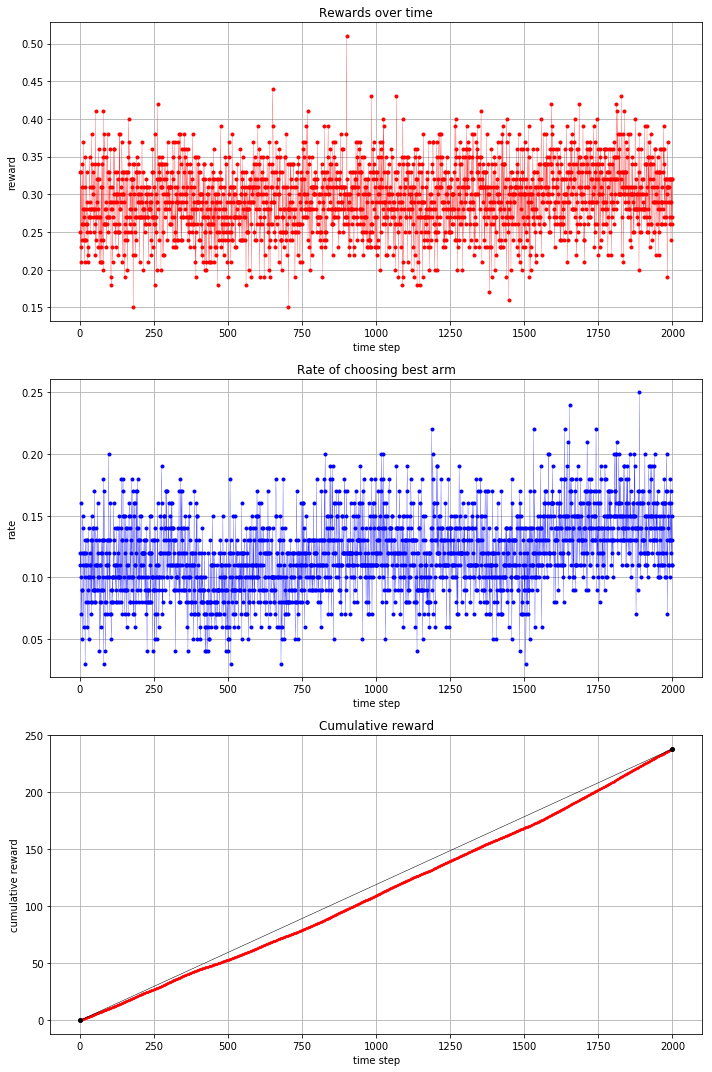

In [342]:
params = {"lr": 0.1}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)